In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [3]:
data = pd.read_csv('data/mnist_train.csv')
data.head()
data = np.array(data)

In [4]:
# Create Data class:
class MNIST(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        x = data[index][1:]
        y = data[index][0]
        return torch.from_numpy(x).float()/256, torch.LongTensor(np.array([y]))
    
    def __len__(self):
        return len(self.data)

In [5]:
# Create dataloader:
mnist = MNIST(data)
data_dl = DataLoader(mnist, batch_size=256, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x, dim=1)

In [7]:
epochs = 3
criterion = nn.NLLLoss()

In [12]:
net = Net([784, 100, 100, 10])

In [13]:
params_ = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-2

In [14]:
# Vanilla SGD
# Training loop:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        
        # Compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # Update parameters:
        for w_, b_ in params_:
            w_.data -= lr * w_.grad.data
            b_.data -= lr * b_.grad.data
            
            # Reset grads:
            w_.grad.data.zero_()
            b_.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [15]:
sgd_losses = [(l.data.numpy()[0]) for l in losses]
sgd_losses = [np.log(l) for l in sgd_losses]

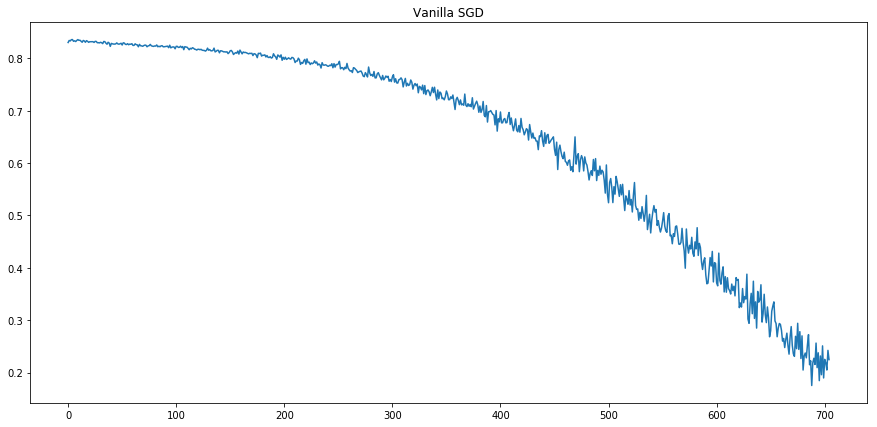

In [16]:
plt.plot(sgd_losses)
title = plt.title('Vanilla SGD')

In [17]:
# SGD with momentum:
# Init architecture:
net = Net([784, 100, 100, 10])
params = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-3
beta = 0.9
epochs = 3

# Momentum velocity initialization for weights and biases:
w_vel = [0 for i in range(len(params))]
b_vel = [0 for i in range(len(params))]

print(w_vel)

# Training loop:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        
        # Compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # Update params:
        for i, param in enumerate(params):
            w_, b_ = param[0], param[1]
            w_vel_ = beta * w_vel[i] + lr * w_.grad.data
            b_vel_ = beta * b_vel[i] + lr * b_.grad.data
            
            w_vel[i] = w_vel_
            b_vel[i] = b_vel_
            
            w_.data -= w_vel_
            b_.data -= b_vel_
            
            w_.grad.data.zero_()
            b_.grad.data.zero_()

[0, 0, 0]
epoch 0
epoch 1
epoch 2


In [18]:
sgd_m_losses = [(l.data.numpy()[0]) for l in losses]
sgd_m_losses = [np.log(l) for l in sgd_m_losses]

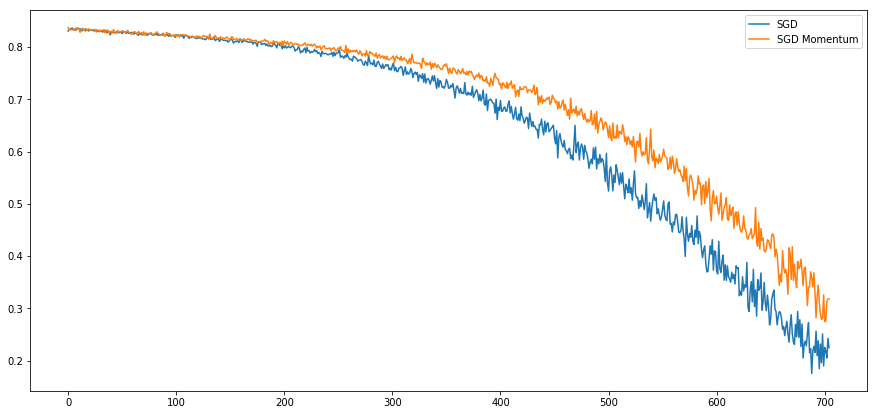

In [19]:
plt.plot(sgd_losses)
plt.plot(sgd_m_losses)
plt.legend(('SGD', 'SGD Momentum'))

In [20]:
# RMSProp / Adadelta:
net = Net([784, 100, 100, 10])
params = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-3
grads_squared = [[torch.zeros_like(wb[0]).data, torch.zeros_like(wb[1]).data] for wb in params]
noise = 1e-8
beta = 0.9
epohs = 3

In [21]:
# Training:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        
        output = net(inputs)
        loss = criterion(output, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # Update the parameters:
        for i, param in enumerate(params):
            w_, b_ = param[0], param[1]
            w_.data -= lr * w_.grad.data / torch.sqrt(grads_squared[i][0] + noise)
            b_.data -= lr * b_.grad.data / torch.sqrt(grads_squared[i][1] + noise)
            
            grads_squared[i][0] = beta * grads_squared[i][0] + (1 - beta) * w_.grad.data * w_.grad.data
            grads_squared[i][1] = beta * grads_squared[i][1] + (1 - beta) * b_.grad.data * b_.grad.data
            
            w_.grad.data.zero_()
            b_.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [22]:
rms_prop_losses = [(l.data.numpy()[0]) for l in losses]
rms_prop_losses = [np.log(l) for l in rms_prop_losses]

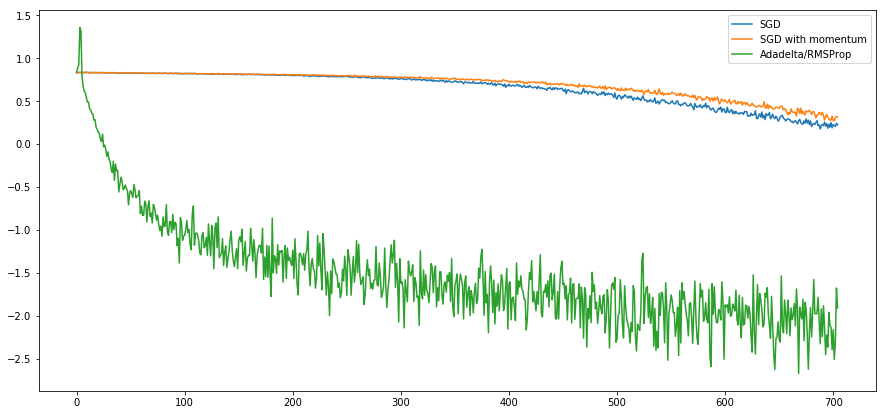

In [24]:
plt.plot(sgd_losses)
plt.plot(sgd_m_losses)
plt.plot(rms_prop_losses)
plt.legend(('SGD', 'SGD with momentum', 'Adadelta/RMSProp'))

In [27]:
# Adam optimizer
# Best of SGD with momentum and RMSProp:
net = Net([784, 100, 100, 10])
params = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-3
epochs = 3
noise = 1e-8
beta1 = 0.9
beta2 = 0.999
m_v = [[[torch.zeros_like(wb[0]).data, torch.zeros_like(wb[0]).data], 
      [torch.zeros_like(wb[1]).data, torch.zeros_like(wb[1]).data]] for wb in params]
t = 0

In [28]:
# Training:
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        t += 1
        inputs, labels  = batch
        inputs, labels = Variable(inputs), Variable(labels)
        output = net(inputs)
        
        loss = criterion(output, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for i, param in enumerate(params):
            w_, b_ = param[0], param[1]
            prev_ = m_v[i][0]
            w_m_t_prev = prev_[0]
            w_v_t_prev = prev_[1]
            
            w_m_t_new = beta1 * w_m_t_prev + (1 - beta1) * w_.grad.data
            w_v_t_new = beta2 * w_v_t_prev + (1 - beta2) * w_.grad.data * w_.grad.data
            
            m_v[i][0][0] = w_m_t_new
            m_v[i][0][1] = w_v_t_new
            
            w_m_t_new = w_m_t_new / (1 - beta1 ** t)
            w_v_t_new = w_v_t_new / (1 - beta2 ** t)
            
            w_.data -= lr * w_m_t_new / (torch.sqrt(w_v_t_new) + noise)
            
            prev_ = m_v[i][1]
            b_m_t_prev = prev_[0]
            b_v_t_prev = prev_[1]
            
            b_m_t_new = beta1 * b_m_t_prev + (1 - beta1) * b_.grad.data
            b_v_t_new = beta2 * b_v_t_prev + (1 - beta2) * b_.grad.data * b_.grad.data
            
            m_v[i][1][0] = b_m_t_new
            m_v[i][1][1] = b_v_t_new
            
            b_m_t_new = b_m_t_new / (1 - beta1 ** t)
            b_v_t_new = b_v_t_new / (1 - beta2 ** t)
            
            b_.data -= lr * b_m_t_new / (torch.sqrt(b_v_t_new) + noise)
            
            w_.grad.data.zero_()
            b_.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [29]:
adam_loss = [(l.data.numpy()[0]) for l in losses]
adam_loss = [np.log(l) for l in adam_loss]

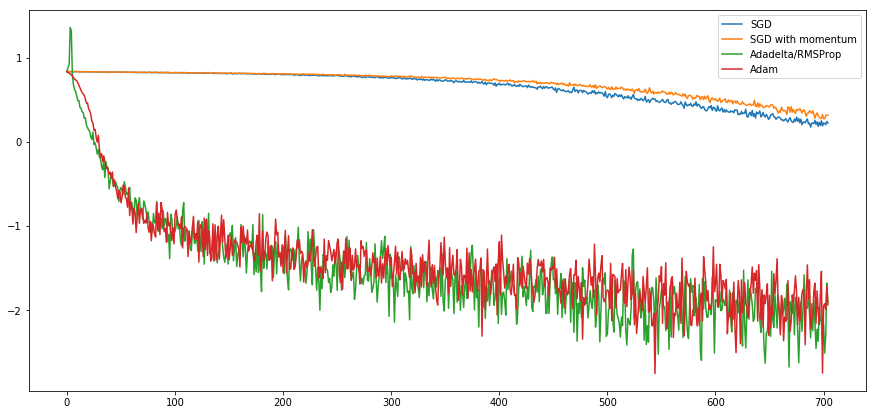

In [30]:
plt.plot(sgd_losses)
plt.plot(sgd_m_losses)
plt.plot(rms_prop_losses)
plt.plot(adam_loss)
plt.legend(('SGD', 'SGD with momentum', 'Adadelta/RMSProp', 'Adam'))